In [37]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
import os
import pandas as pd
import numpy as np

#Set paths and set option to print entire tables
path = "./data/"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Set paths for CSV
train_path = os.path.join(path,"UNSW_NB15_training-set.csv")
test_path = os.path.join(path,"UNSW_NB15_test-set.csv")

#Read the CSVs 
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

#Fix ID's Name
train_df.rename(columns={'ï»¿id': 'id'}, inplace=True)
test_df.rename(columns={'ï»¿id': 'id'}, inplace=True)

#Replace '-' (missing value) with NA
train_df.replace('-', pd.NA, inplace=True)
test_df.replace('-', pd.NA, inplace=True)
  
#Drop missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

##TO-DO, DROP UNIQUE ROWS
test_df[0:10]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,36,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,62,252,5976.375000,8342.531250,2,2,109.319333,124.932859,5929.211713,192.590406,255,794167371,1624757001,255,0.206572,0.108393,0.098179,82,147,1,184,2,1,1,1,1,2,0,0,1,1,3,0,Normal,0
40,41,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,62,252,3876.882812,5940.385254,2,2,170.481889,159.070562,11933.065600,244.118016,255,708428911,3141441573,255,0.180318,0.103612,0.076706,83,127,1,187,2,1,1,1,1,2,0,0,1,1,3,0,Normal,0
45,46,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,62,252,5641.147461,7498.874512,2,2,117.706556,132.899281,6102.668305,255.756219,255,1853677305,1202418679,255,0.274887,0.128459,0.146428,83,142,1,165,1,1,1,1,1,1,0,0,1,3,1,0,Normal,0
49,50,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,62,252,5847.268066,10281.177730,2,2,110.060889,100.616555,7172.956819,143.497953,255,1528762476,1066585482,255,0.181441,0.084249,0.097192,80,141,1,261,2,1,18,1,1,2,0,0,1,1,2,0,Normal,0
72,73,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,62,252,5057.083984,6014.492676,2,2,118.501635,175.467000,6491.561713,252.408328,255,1182907296,802589817,255,0.140062,0.074510,0.065552,75,140,1,157,1,1,1,1,1,1,0,0,1,2,1,0,Normal,0
89,90,2.417396,tcp,http,FIN,12,10,896,1142,8.687033,62,252,2720.282471,3402.007568,2,2,219.671639,251.911219,13318.121680,368.903437,255,1647371567,938705912,255,0.301504,0.150194,0.151310,75,114,1,126,1,1,2,1,1,1,0,0,1,1,1,0,Normal,0
99,100,1.979445,tcp,http,FIN,10,10,810,1228,9.598650,62,252,2946.280518,4469.939941,2,2,219.938333,211.908000,14679.526850,514.389156,255,504743724,17824254,255,0.141090,0.071357,0.069733,81,123,1,168,2,1,1,1,1,2,0,0,1,1,2,0,Normal,0
116,117,1.538604,tcp,http,FIN,10,10,814,1266,12.348856,62,252,3811.247070,5927.451172,2,2,170.860889,158.795219,9513.325933,271.657688,255,664847518,2707919610,255,0.333902,0.109439,0.224463,81,127,1,188,2,1,1,1,1,2,0,0,1,2,2,0,Normal,0
130,131,1.625287,tcp,http,FIN,12,8,876,1182,11.690243,62,252,3952.532471,5094.484863,2,2,147.753369,221.341281,7502.326999,308.739156,255,1189974610,4041664482,255,0.184153,0.075141,0.109012,73,148,1,189,1,1,2,1,1,1,0,0,1,1,1,0,Normal,0
135,136,1.048635,tcp,http,FIN,10,8,824,1206,16.211551,62,252,5660.692383,8056.187500,2,2,116.515000,129.349430,6160.721977,249.897156,255,3719681799,1268959706,255,0.263248,0.142526,0.120722,82,151,1,201,4,1,1,1,1,4,0,0,1,1,4,0,Normal,0


In [40]:
# Send the expected numeric and categorical columns to normalization. Send target to text_index.  
NumericColumns = ['dur','spkts','dpkts','sbytes','dbytes','rate','sttl','dttl','sload','dload','sloss','dloss','sinpkt','dinpkt','sjit','djit','swin','stcpb','dtcpb','tcprtt',
               'synack','ackdat','smean','dmean','trans_depth','response_body_len','ct_srv_src','ct_state_ttl','ct_dst_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd',
               'ct_flw_http_mthd','ct_src_ltm','ct_srv_dst','is_sm_ips_ports']
CategoricalColumns = ['proto', 'service', 'state','attack_cat']
for i in NumericColumns:
    encode_numeric_zscore(train_df,i)
    encode_numeric_zscore(test_df,i)
for i in CategoricalColumns:
    encode_text_index(train_df,i)
    encode_text_index(test_df,i)
train_df.drop(columns=['is_sm_ips_ports'], inplace=True)
test_df.drop(columns=['is_sm_ips_ports'], inplace=True)
train_df[0:10]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,attack_cat,label
3,4,0.174677,0,2,1,-0.048030,-0.044580,-0.055932,-0.077782,-0.624123,-1.042527,1.554587,-0.610101,-0.216534,-0.061567,-0.055844,0.465346,0.190108,-0.125318,0.921565,1.185734,0.159327,0.116305,255,-0.548899,-0.511111,-0.542046,-0.358947,-0.230851,-0.197312,-0.057780,-0.931741,-0.340489,-0.811222,1,-0.890285,-0.790888,5.266767,5.266767,-0.278273,-0.855604,-0.927297,6,0
11,12,0.266079,0,8,1,0.216764,0.076680,0.169685,-0.069496,-0.623956,-1.042527,1.554587,-0.607521,-0.211838,0.228984,0.022395,-0.036952,0.131492,0.015802,-0.156252,1.185734,0.698403,-0.024568,255,1.387128,0.976391,1.689012,3.682398,-0.171035,-0.197312,-0.057780,-0.857352,-0.340489,-0.911291,1,-0.890285,-0.865254,-0.175733,-0.175733,-0.278273,-0.955804,-0.927297,6,0
15,16,-0.198900,1,9,2,-0.100988,-0.135525,-0.057916,-0.082207,2.287049,0.822646,-0.717582,2.795841,-0.219823,-0.072328,-0.102787,-0.182312,-0.159170,-0.137528,-0.179661,-0.843349,-0.672360,-0.673920,0,-0.548899,-0.511111,-0.542046,-0.278781,-0.486063,-0.197312,-0.057780,-0.931741,0.851546,-0.911291,1,-0.890285,-0.716523,-0.175733,-0.175733,-0.278273,-0.855604,-0.927297,6,0
17,18,-0.111472,0,4,1,-0.058621,-0.074895,-0.054992,-0.075909,-0.623952,-1.042527,1.554587,-0.609941,-0.200730,-0.050806,-0.071491,0.002937,0.025344,-0.037382,-0.163820,1.185734,2.244595,1.652802,255,1.227288,1.155081,1.199529,-0.198614,0.060251,0.689287,-0.056479,-0.782963,-0.340489,-0.911291,1,-0.890285,-0.865254,-0.175733,-0.175733,0.719265,-0.955804,-0.778749,6,0
21,22,-0.123810,0,4,1,-0.058621,-0.090052,-0.054433,-0.080667,-0.623945,0.822646,1.554587,-0.609873,-0.214631,-0.050806,-0.087139,-0.033117,0.059835,-0.046634,-0.161566,1.185734,1.330366,1.982709,255,1.731003,1.039913,2.288498,-0.132594,-0.306617,0.689287,-0.057780,-0.559796,-0.340489,-0.911291,1,-0.890285,-0.939620,-0.175733,-0.175733,0.719265,-0.855604,-0.778749,6,0
22,23,0.015398,0,2,0,-0.037438,-0.044580,-0.055680,-0.076748,-0.624052,-1.042527,1.554587,-0.610070,-0.212748,-0.018522,-0.008901,0.132049,0.071915,0.044851,-0.165155,1.185734,0.076542,-0.629207,255,1.110896,0.968989,1.163280,-0.373094,-0.171035,-0.197312,-0.057780,-0.931741,2.043582,-0.911291,1,-0.890285,-0.865254,5.266767,5.266767,-0.278273,-0.855604,-0.927297,6,0
28,29,-0.077512,0,4,1,-0.058621,-0.074895,-0.053744,-0.076231,-0.624022,0.822646,1.554587,-0.609945,-0.206774,-0.050806,-0.071491,0.074896,0.118197,0.010140,-0.155526,1.185734,0.566166,2.464354,255,0.704337,0.723427,0.627117,-0.052428,0.032337,0.689287,-0.056403,-0.559796,-0.340489,-0.911291,1,-0.890285,-0.865254,-0.175733,-0.175733,0.719265,-0.955804,-0.407378,6,0
30,31,-0.037620,0,4,1,-0.058621,-0.014265,-0.055146,-0.011986,-0.624003,-1.042527,1.554587,-0.610034,-0.096168,-0.050806,-0.024548,0.159425,0.009624,0.115578,0.589336,1.185734,0.531817,-0.387370,255,1.010109,0.532859,1.410330,-0.217477,2.560532,0.689287,0.012099,-0.559796,-0.340489,-0.911291,1,-0.890285,-0.865254,-0.175733,-0.175733,0.719265,-0.855604,-0.927297,6,0
31,32,-0.137897,0,4,1,-0.058621,-0.090052,-0.053501,-0.080667,-0.623885,-1.042527,1.554587,-0.609737,-0.213431,-0.050806,-0.087139,-0.067017,0.014402,-0.068876,-0.165638,1.185734,-0.205661,2.123829,255,0.936781,0.906930,0.890011,-0.024133,-0.306617,0.689287,-0.057780,-0.634185,-0.340489,-0.911291,1,-0.890285,-0.716523,-0.175733,-0.175733,0.719265,-0.955804,-0.407378,6,0
32,33,-0.123935,0,4,1,-0.058621,-0.074895,-0.055235,-0.069220,-0.623910,-1.042527,1.554587,-0.609924,-0.173894,-0.050806,-0.071491,-0.023471,0.000575,-0.045958,-0.162855,1.185734,2.416942,-0.036425,255,0.797801,0.305394,1.230820,-0.226908,0.642453,0.689287,-0.048887,-0.782963,-0.340489,-0.911291,1,-0.

In [41]:
columns_of_interest = ['proto', 'service', 'state', 'attack_cat']
common_categories_dict = {}

#Get common categories for each column
for column in columns_of_interest:
    train_categories = set(train_df[column].unique())
    test_categories = set(test_df[column].unique())
    common_categories_dict[column] = train_categories.intersection(test_categories)

#Filter the DataFrames for each column based on common categories
for column in columns_of_interest:
    train_df = train_df[train_df[column].isin(common_categories_dict[column])]
    test_df = test_df[test_df[column].isin(common_categories_dict[column])]

#Check unique values
for column in columns_of_interest:
    print(f"Filtered Train {column} Categories:", train_df[column].unique())
    print(f"Filtered Test {column} Categories:", test_df[column].unique())


Filtered Train proto Categories: [0 1]
Filtered Test proto Categories: [0 1]
Filtered Train service Categories: [ 2  8  9  4  3  1 10  7  6  0 11  5]
Filtered Test service Categories: [ 4  2  3  8  6  1  9 11  0  5  7 10]
Filtered Train state Categories: [1 2 0 4 3]
Filtered Test state Categories: [2 3 1 0 4]
Filtered Train attack_cat Categories: [6 1 4 7 3 0 2 5]
Filtered Test attack_cat Categories: [5 2 6 3 1 7 0 4]


CLASS
CLASS
Train X shape: (81059, 43)
Train Y shape: (81059, 2)
Test X shape: (35179, 43)
Test Y shape: (35179, 2)
Epoch 1/100


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2534/2534 - 5s - 2ms/step - loss: 35.5323 - val_loss: 1.4577
Epoch 2/100
2534/2534 - 6s - 2ms/step - loss: 0.3532 - val_loss: 1.4536
Epoch 3/100
2534/2534 - 6s - 2ms/step - loss: 0.6634 - val_loss: 1.1113
Epoch 4/100
2534/2534 - 5s - 2ms/step - loss: 0.5798 - val_loss: 1.5670
Epoch 5/100
2534/2534 - 5s - 2ms/step - loss: 0.5715 - val_loss: 2.1597
Epoch 6/100
2534/2534 - 5s - 2ms/step - loss: 0.5485 - val_loss: 4.2876
Epoch 7/100
2534/2534 - 5s - 2ms/step - loss: 0.5918 - val_loss: 4.6113
Epoch 8/100
2534/2534 - 5s - 2ms/step - loss: 0.5461 - val_loss: 6.2203
Epoch 8: early stopping
Epoch 1/100
2534/2534 - 6s - 2ms/step - loss: 29.3031 - val_loss: 1.3336
Epoch 2/100
2534/2534 - 5s - 2ms/step - loss: 0.6962 - val_loss: 4.1290
Epoch 3/100
2534/2534 - 5s - 2ms/step - loss: 0.5273 - val_loss: 7.4260
Epoch 4/100
2534/2534 - 5s - 2ms/step - loss: 0.5435 - val_loss: 11.6340
Epoch 5/100
2534/2534 - 5s - 2ms/step - loss: 0.5336 - val_loss: 9.6851
Epoch 6/100
2534/2534 - 5s - 2ms/step - loss: 0.5

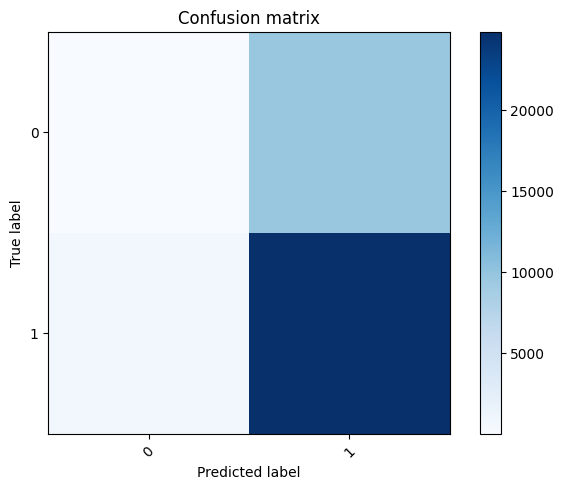

              precision    recall  f1-score   support

           0       0.03      0.00      0.00      9625
           1       0.72      0.97      0.83     25554

    accuracy                           0.71     35179
   macro avg       0.38      0.49      0.42     35179
weighted avg       0.53      0.71      0.60     35179



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [42]:
label = encode_text_index(train_df,"label")
x, y = to_xy(train_df, "label")
x_test, y_test = to_xy(test_df, "label")

print("Train X shape:", x.shape)
print("Train Y shape:", y.shape)
print("Test X shape:", x_test.shape)
print("Test Y shape:", y_test.shape)

checkpointer = ModelCheckpoint(filepath="dnn/model.keras", verbose=0, save_best_only=True) # save best model
for i in range(3):
    model = Sequential()
    model.add(Dense(500, input_dim=x.shape[1], activation='relu')) # More neurons
    model.add(Dropout(0.1))  # Dropout to reduce overfitting
    model.add(Dense(2, activation='softmax')) # Output layer
    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto') 
    model.fit(x, y, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=2, epochs=100)

model.load_weights('dnn/model.keras') # load weights from best model 

import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()
print(classification_report(y_true, pred))

#pred = pred[:,1] # Only positive class (M)
#plot_roc(pred,y_true)